# Import Libraries

In [96]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import plot_model

# Declare Constants

In [97]:
DATA_PATH = 'Dataset'
TRAIN_PATH = os.path.join(DATA_PATH, 'Train')
TEST_PATH = os.path.join(DATA_PATH, 'Test')
CATEGORIES = ['Fire', 'NoFire']

# Dataset Insight

In [98]:
num_training_set = 0
num_test_set = 0

files = len(os.listdir(os.path.join(TRAIN_PATH, 'Fire')))
print(f"Train-Fire - {files} files")
num_training_set = num_training_set + files

files = len(os.listdir(os.path.join(TRAIN_PATH, 'NoFire')))
print(f"Train-NoFire - {files} files \n")
num_training_set = num_training_set+files


files = len(os.listdir(os.path.join(TEST_PATH, 'Fire')))
print(f"Test-Fire - {files} files")
num_test_set = num_test_set+files

files = len(os.listdir(os.path.join(TEST_PATH, 'NoFire')))
print(f"Test-NoFire - {files} files\n")
num_test_set = num_test_set+files

print(f"Total Train: {num_training_set}")
print(f"Total Test: {num_test_set}")

Train-Fire - 1124 files
Train-NoFire - 1301 files 

Test-Fire - 593 files
Test-NoFire - 278 files

Total Train: 2425
Total Test: 871


# Plot Sample Images

## Image Plotting Function

In [99]:
# Select 5 random images from the train dataset
def plot_images(PATH, Category):
  category_dir = os.path.join(PATH, Category)

  random_images = random.sample(os.listdir(category_dir), 6)

  # Display the randomly selected images with labels
  images = []
  for image_name in random_images:
      image_path = os.path.join(category_dir, image_name)
      images.append(cv2.imread(image_path))

  num_rows = 2
  num_cols = 3

  plt.figure(figsize=(6, 4))  # Adjust the figure size as needed

  for i in range(len(images)):
      plt.subplot(num_rows, num_cols, i + 1)
      plt.imshow(images[i])
      plt.axis('off')  # Hide axis labels

  plt.tight_layout()  # Adjust the layout to avoid overlapping
  plt.show()



## Plot Train Fire Samples

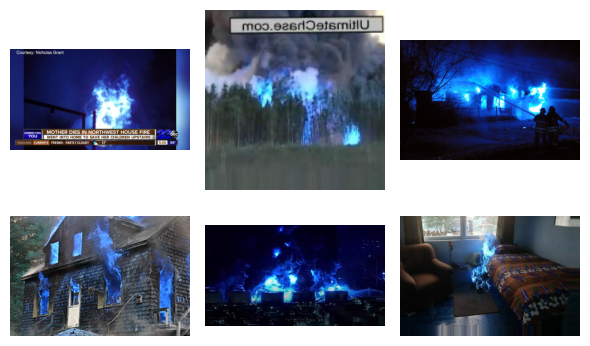

In [100]:
plot_images(TRAIN_PATH, 'Fire')

## Plot Train NoFire Samples

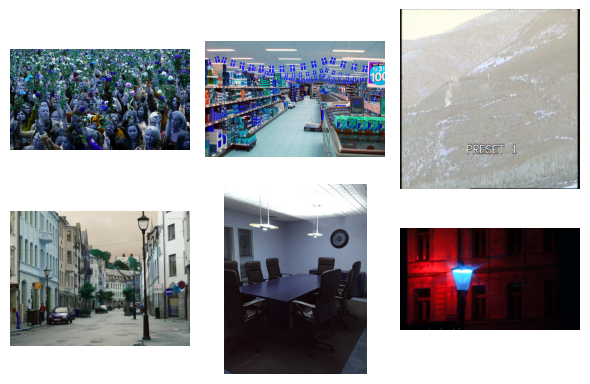

In [101]:
plot_images(TRAIN_PATH, 'NoFire')

## Plot Test Fire Samples

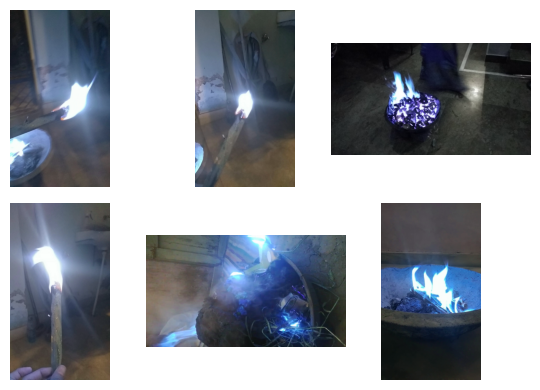

In [102]:
plot_images(TEST_PATH, 'Fire')

## Plot Test NoFire Images

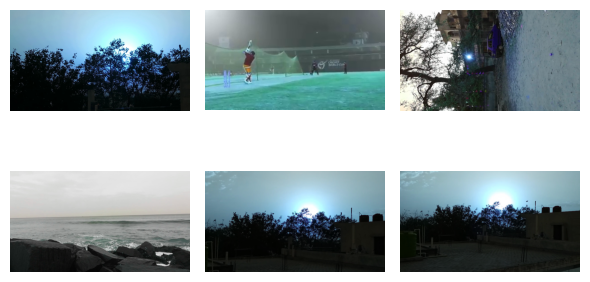

In [103]:
plot_images(TEST_PATH, 'NoFire')

# Prepare Dataset

In [104]:
IMG_SIZE = 64 #images will be resized to a square shape with dimensions 64x64 pixels

def prepare_data(PATH):
    data = []
    for category in CATEGORIES:
        path = os.path.join(PATH, category) # Construct the path to the category's directory
        class_num = CATEGORIES.index(category) # Get the class index for the current category

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path, img)) # Read the image using OpenCV's imread function
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resize the image to a specified size
                data.append([new_array, class_num]) # Append the resized image and its class index to the training data list
            except Exception as e:
                pass
    return data

training_data = prepare_data(TRAIN_PATH) # Create the training data using the create_training_data function
np.random.shuffle(training_data)  # Shuffle the training data

X = []  # Initialize an empty list to store the features (input data)
Y = [] # Initialize an empty list to store the labels (output data)

for features, label in training_data:
    X.append(features) # Append the features (input data) to the X list
    Y.append(label) # Append the label (output data) to the Y list

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # to Convert the X list to a NumPy array and reshape it to match the desired input shape
X = X / 255.0 # to Normalize the pixel values in X by dividing them by 255.0 (scaling them between 0 and 1)
Y = np.array(Y)  # for Converting the Y list to a NumPy array


100%|██████████| 1301/1301 [00:07<00:00, 177.53it/s]


## Split Train and Val

In [105]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# MobileNet Model

In [106]:
from keras.applications import MobileNet, VGG16, VGG19, Xception
from keras.models import Sequential
from keras.layers import DepthwiseConv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Conv2D

mobileNet_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
fine_tune_layers = 2
for layer in mobileNet_base_model.layers[:-fine_tune_layers]:
    layer.trainable = False

model = Sequential()
model.add(mobileNet_base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 2, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_58 (Dense)            (None, 32)                32800     
                                                                 
 batch_normalization_51 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_53 (Dropout)        (None, 32)                0         
                                                     

In [107]:
# plot_model(model, show_shapes=True, show_layer_names=True)

## Train Model

In [108]:
from keras.callbacks import ModelCheckpoint

filepath = 'Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]


history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/100


2024-04-20 16:48:40.377135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/53 [===========================>..] - ETA: 0s - loss: 0.6188 - accuracy: 0.7402

2024-04-20 16:48:41.958750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.82669, saving model to Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5

Epoch 1: val_loss improved from inf to 0.39610, saving model to Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5


/Users/mah_prince/miniconda3/envs/FireNet/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


53/53 [==============================] - 3s 42ms/step - loss: 0.6129 - accuracy: 0.7441 - val_loss: 0.3961 - val_accuracy: 0.8267
Epoch 2/100
50/53 [===========================>..] - ETA: 0s - loss: 0.3587 - accuracy: 0.8506
Epoch 2: val_accuracy improved from 0.82669 to 0.86245, saving model to Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5

Epoch 2: val_loss improved from 0.39610 to 0.32751, saving model to Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5
53/53 [==============================] - 2s 31ms/step - loss: 0.3550 - accuracy: 0.8496 - val_loss: 0.3275 - val_accuracy: 0.8624
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.8679
Epoch 3: val_accuracy improved from 0.86245 to 0.89271, saving model to Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5

Epoch 3: val_loss improved from 0.32751 to 0.26648, saving model to Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5
53/53 [==============================] - 1s 28ms/step - loss: 0.3163 - a

## Plot Tran VS Val Chart

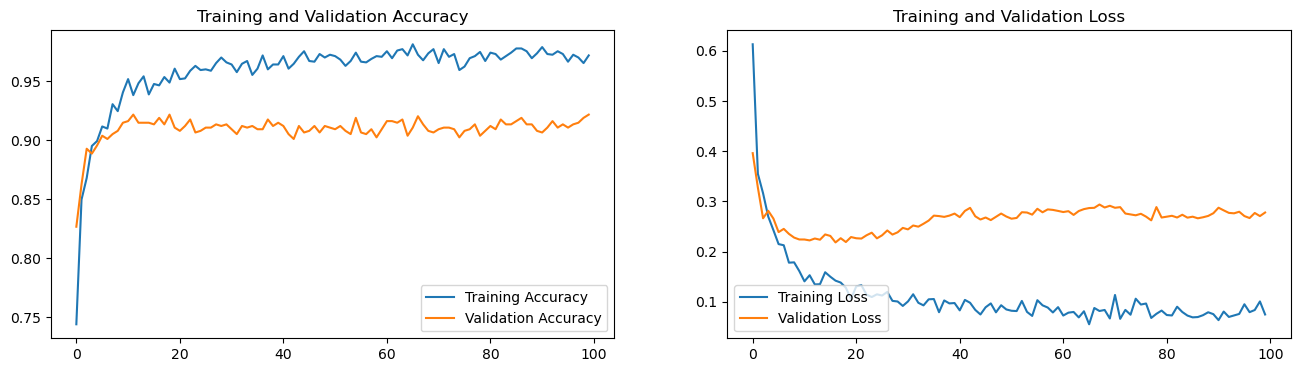

In [109]:
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module for plotting graph

epochs_range = range(100)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

# VGG16

In [110]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
fine_tune_layers = 1
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False

model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dense_60 (Dense)            (None, 32)                16416     
                                                                 
 batch_normalization_52 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_54 (Dropout)        (None, 32)                0         
                                                                 
 dense_61 (Dense)            (None, 2)               

In [111]:
from keras.callbacks import ModelCheckpoint

filepath = 'Dataset/NEWTrainedModel/VGG16/FireNetv3.0.h5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/100


2024-04-20 16:50:42.520221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


52/53 [============================>.] - ETA: 0s - loss: 0.7148 - accuracy: 0.7031

2024-04-20 16:50:45.584862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.63549, saving model to Dataset/NEWTrainedModel/VGG16/FireNetv3.0.h5

Epoch 1: val_loss improved from inf to 0.58571, saving model to Dataset/NEWTrainedModel/VGG16/FireNetv3.0.h5
53/53 [==============================] - 5s 84ms/step - loss: 0.7187 - accuracy: 0.7011 - val_loss: 0.5857 - val_accuracy: 0.6355
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.7883
Epoch 2: val_accuracy improved from 0.63549 to 0.78680, saving model to Dataset/NEWTrainedModel/VGG16/FireNetv3.0.h5

Epoch 2: val_loss improved from 0.58571 to 0.42333, saving model to Dataset/NEWTrainedModel/VGG16/FireNetv3.0.h5
53/53 [==============================] - 4s 77ms/step - loss: 0.4662 - accuracy: 0.7883 - val_loss: 0.4233 - val_accuracy: 0.7868
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8243
Epoch 3: val_accuracy improved from 0.78680 to 0.84594, saving model to Dataset/NEWTrainedMode

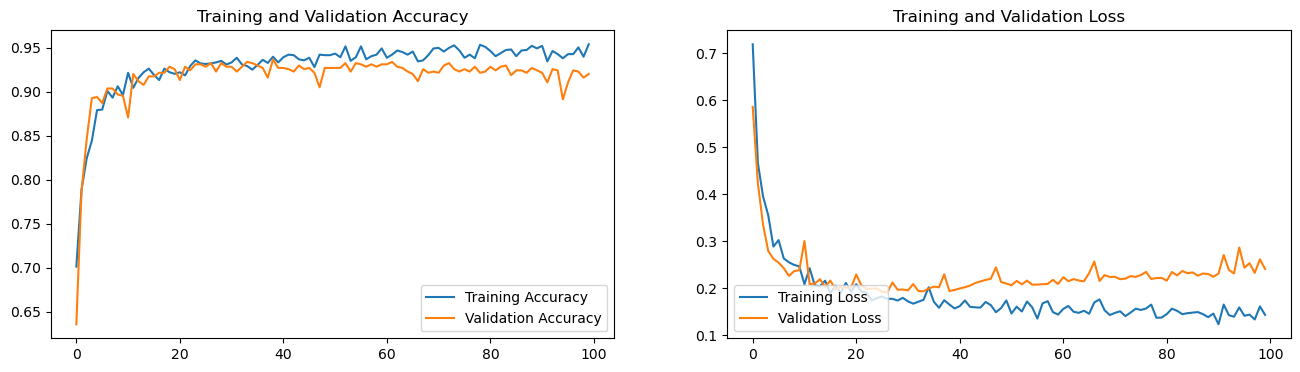

In [112]:
epochs_range = range(100)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

# VGG19

In [113]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
fine_tune_layers = 1
for layer in base_model.layers[:-fine_tune_layers]:
    layer.trainable = False

model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
 9 (GlobalAveragePooling2D)                                      
                                                                 
 dense_62 (Dense)            (None, 32)                16416     
                                                                 
 batch_normalization_53 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_55 (Dropout)        (None, 32)                0         
                                                                 
 dense_63 (Dense)            (None, 2)               

In [114]:
from keras.callbacks import ModelCheckpoint

filepath = 'Dataset/NEWTrainedModel/VGG19/FireNetv3.0.h5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/100


2024-04-20 16:58:38.250296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.7364

2024-04-20 16:58:45.363143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.55708, saving model to Dataset/NEWTrainedModel/VGG19/FireNetv3.0.h5

Epoch 1: val_loss improved from inf to 0.79475, saving model to Dataset/NEWTrainedModel/VGG19/FireNetv3.0.h5
53/53 [==============================] - 11s 201ms/step - loss: 0.6196 - accuracy: 0.7364 - val_loss: 0.7948 - val_accuracy: 0.5571
Epoch 2/100
53/53 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.8078
Epoch 2: val_accuracy improved from 0.55708 to 0.62173, saving model to Dataset/NEWTrainedModel/VGG19/FireNetv3.0.h5

Epoch 2: val_loss improved from 0.79475 to 0.72163, saving model to Dataset/NEWTrainedModel/VGG19/FireNetv3.0.h5
53/53 [==============================] - 10s 188ms/step - loss: 0.4651 - accuracy: 0.8078 - val_loss: 0.7216 - val_accuracy: 0.6217
Epoch 3/100
53/53 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8149
Epoch 3: val_accuracy improved from 0.62173 to 0.77166, saving model to Dataset/NEWTrained

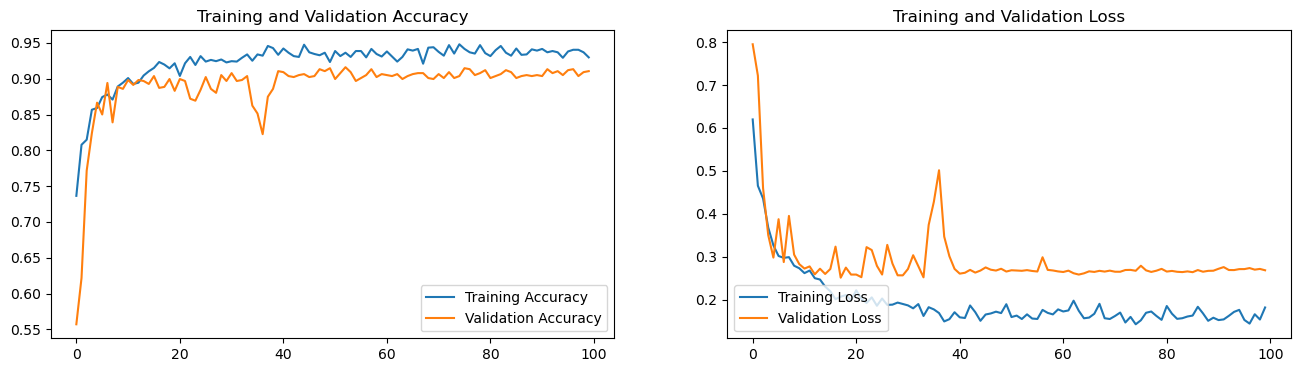

In [115]:
epochs_range = range(100)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

# Plot Results of Different Models

## Load Models

In [117]:
from tensorflow.keras.models import load_model

MobileNet_model = load_model('Dataset/NEWTrainedModel/MobileNet/FireNetv3.0.h5')
VGG16_model = load_model('Dataset/NEWTrainedModel/VGG16/FireNetv3.0.h5')
VGG19_model = load_model('Dataset/NEWTrainedModel/VGG19/FireNetv3.0.h5')

## Functions for Confusion Matrix and Performance Metrics

In [123]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_true, Y_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_true, Y_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)


# Defining function for Performance metrics
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
    print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

# Defining function for classification report
def display_classification_report(true_labels, predicted_labels, Classes):
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
    print("\nReport:\n"+report)

## MobileNet Performance

In [124]:
predictions = MobileNet_model.predict(X_val) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
    Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels
Y_true = Y_val # true labels

23/23 [==============================] - 0s 16ms/step


None


<Axes: xlabel='Predicted label', ylabel='True label'>

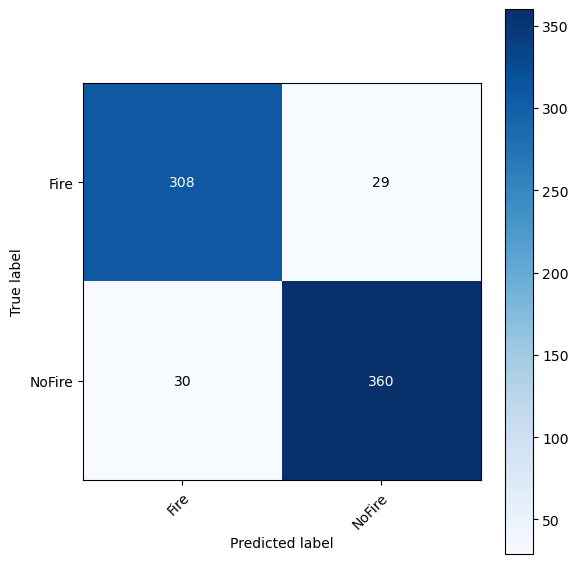

In [126]:
# Not Normalized

from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES)

None


<Axes: xlabel='Predicted label', ylabel='True label'>

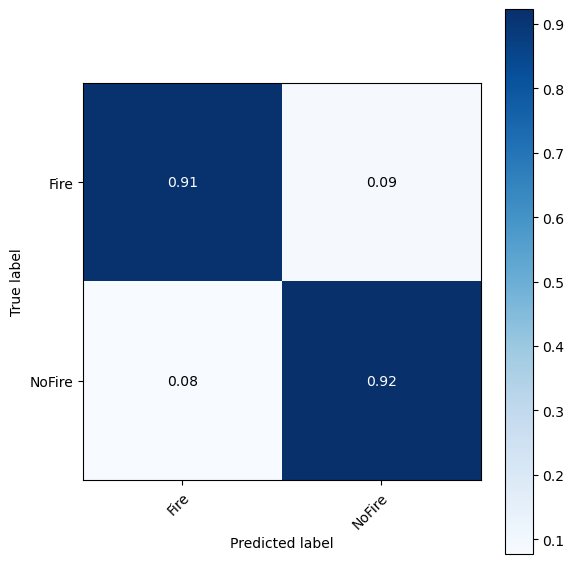

In [127]:
# Normalized
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES, normalize=True)

### Performance Metrics Function

In [128]:
get_metrics(Y_true, Y_pred)

display_classification_report(Y_true, Y_pred, CATEGORIES)

Accuracy: 0.9188
Precision: 0.9189
Recall: 0.9188
F1 Score: 0.9189

Report:
              precision    recall  f1-score   support

        Fire       0.91      0.91      0.91       337
      NoFire       0.93      0.92      0.92       390

    accuracy                           0.92       727
   macro avg       0.92      0.92      0.92       727
weighted avg       0.92      0.92      0.92       727



## VGG16

2024-04-20 19:01:45.707584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 49ms/step
None
None
Accuracy: 0.9367
Precision: 0.9367
Recall: 0.9367
F1 Score: 0.9367

Report:
              precision    recall  f1-score   support

        Fire       0.93      0.93      0.93       337
      NoFire       0.94      0.94      0.94       390

    accuracy                           0.94       727
   macro avg       0.94      0.94      0.94       727
weighted avg       0.94      0.94      0.94       727



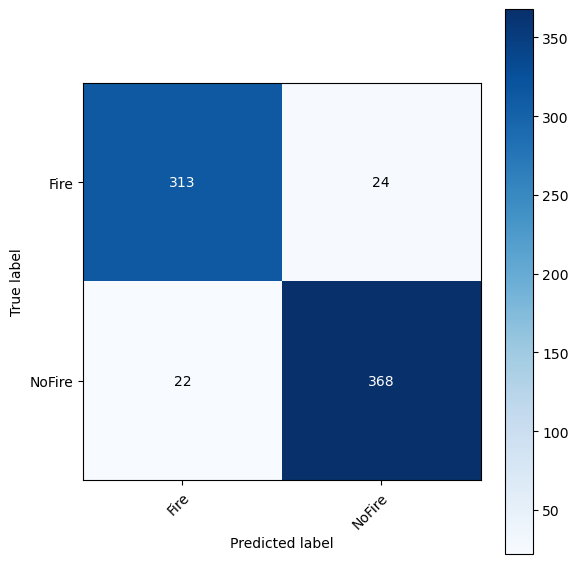

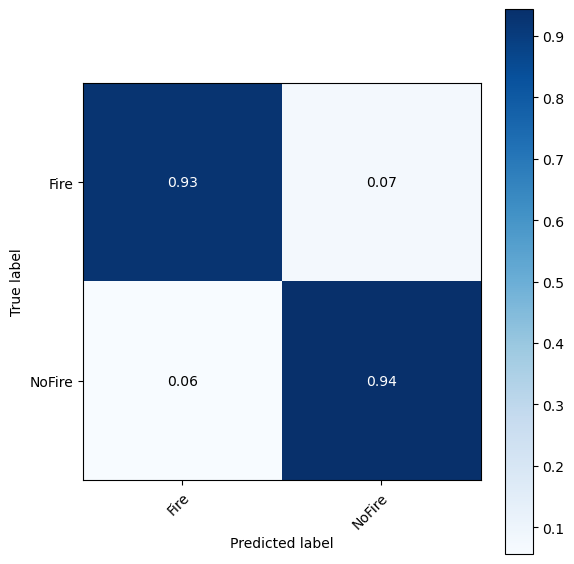

In [129]:
predictions = VGG16_model.predict(X_val) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
    Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels
Y_true = Y_val # true labels

# Not Normalized
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES)
# Normalized
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES, normalize=True)

get_metrics(Y_true, Y_pred)
display_classification_report(Y_true, Y_pred, CATEGORIES)

## VGG 19

2024-04-20 19:02:25.443537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 59ms/step
None
None
Accuracy: 0.9161
Precision: 0.9166
Recall: 0.9161
F1 Score: 0.9159

Report:
              precision    recall  f1-score   support

        Fire       0.93      0.89      0.91       337
      NoFire       0.91      0.94      0.92       390

    accuracy                           0.92       727
   macro avg       0.92      0.91      0.92       727
weighted avg       0.92      0.92      0.92       727



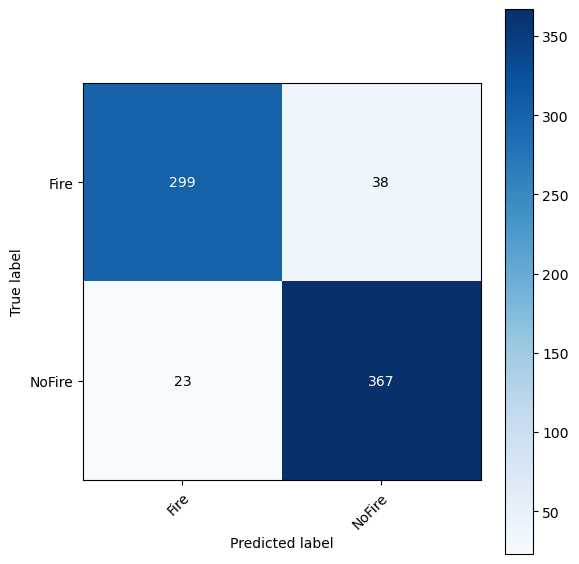

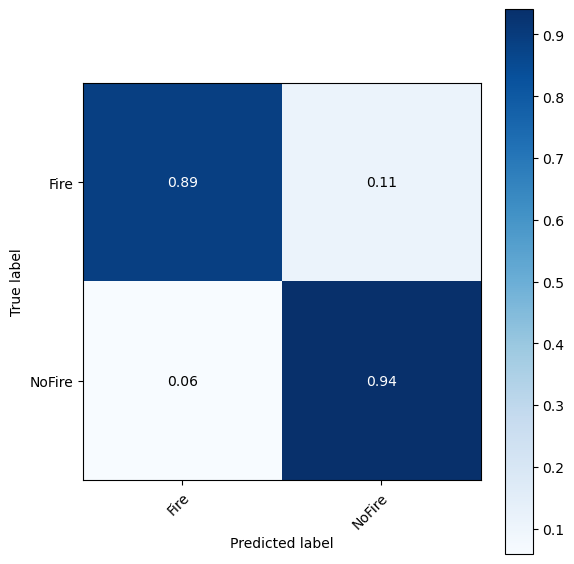

In [130]:
predictions = VGG19_model.predict(X_val) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
    Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels
Y_true = Y_val # true labels

# Not Normalized
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES)
# Normalized
plot_confusion_matrix(Y_true, Y_pred, Classes = CATEGORIES, normalize=True)

get_metrics(Y_true, Y_pred)
display_classification_report(Y_true, Y_pred, CATEGORIES)